# Auxiliary functions

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
np.set_printoptions(linewidth=np.inf)

def partial(ff, k, p, H=1e-6):
    '''
    Returns the partial derivative of a function
    
    ff = function to be differentiated
    k = index of the variable with respect to which the derivative is taken
    p = point where to calculate the derivative
    H = approximation step size
    '''
    
    inf,sup = np.copy(p),np.copy(p) # points where to calculate ff
    inf[k] -= H/2 # (..., x_i - H/2, ...)
    sup[k] += H/2 # (..., x_i + H/2, ...)
    
    return (ff(sup) - ff(inf)) / H

def Simpson(ff, a, b, N=100):
    '''
    Returns the integral of a function between a and b

    ff = function to be integrated
    a, b = limits of integration
    N = number of steps
    '''
    
    h = (b-a)/N
    x = np.linspace(a,b,N+1)
    y = ff(x)
    I = h/3 * (y[0] + y[-1] + 4*np.sum(y[1:N:2]) + 2*np.sum(y[2:N-1:2]))
    return I

def Fisher_matrix(p, ffs, sigmas):
    '''
    Returns the Fisher matrix of a model
    
    p = list of model parameters
    ffs = array of the functions that describe the observables
    sigmas = array of the Gaussian errors of the observables
    '''

    m = len(p)
    F = np.zeros([m,m]) # matrix size
    
    for i in range(m):
        for j in range(m):

            part_i, part_j = np.vectorize(lambda ff: partial(ff,i,p)), np.vectorize(lambda ff: partial(ff,j,p))
            F[i,j] = np.sum((part_i(ffs) * part_j(ffs)) / sigmas**2) # calculates each entry

    return F

def Fisher_matrix_wPriors(p, ffs, sigmas, priors):
    '''
    Returns the Fisher matrix of a model with separate priors
    
    p = list of model parameters
    ffs = array of the functions that describe the observables
    sigmas = array of the Gaussian errors of the observables
    priors = array of the priors to be used (same length and order as p)
    '''
    
    F = Fisher_matrix(p, ffs, sigmas)
    
    D = np.zeros_like(priors, dtype = float)
    mask = priors != 0
    D[mask] = priors[mask]**-2
    F_priors = np.diag(D) # creates a diagonal matrix with the priors

    F += F_priors # adds priors to initial matrix

    return F

def cov_matrix(F):
    '''
    Returns the covariance matrix of a model

    F = Fisher matrix of the model
    '''
    
    return np.mat(F).I # inverse of the Fisher matrix

def unc(F):
    '''
    Returns the uncertainties of the model parameters
    
    F = Fisher matrix of the model
    '''

    C = cov_matrix(F)
    return np.sqrt(abs(np.diag(C)))

def rho(F, i, j):
    '''
    Returns the correlation coefficient between parameters i and j

    F = Fisher matrix of the model
    i, j = indexes of the parameters for which to calculate the correlation coefficient
    '''
    
    C = cov_matrix(F)
    rho = C[i,j]/np.sqrt(C[i,i]*C[j,j])

    return rho

def ellipse(F, i, j, delta_chi2=2.3):

    '''
    Returns the axes and the angle from the x-axis of the confidence ellipse of parameters i and j

    F = Fisher matrix of the model
    i, j = indexes of the parameters for which to calculate the correlation coefficient
    delta_csi2 = confidence interval of interest
    '''

    C = cov_matrix(F)
    C_ij = C[np.ix_([i, j], [i, j])]
    
    A2 = (C_ij[0,0]+C_ij[1,1]) / 2. + np.sqrt((C_ij[0,0]-C_ij[1,1])**2 / 4. + C_ij[0,1]**2)
    a2 = (C_ij[0,0]+C_ij[1,1]) / 2. - np.sqrt((C_ij[0,0]-C_ij[1,1])**2 / 4. + C_ij[0,1]**2)
    if C_ij[0,0] >= C_ij[1,1]:
        ai2, aj2 = A2, a2
    else:
        ai2, aj2 = a2, A2

    angle = 0.5*np.arctan((2*C_ij[0,1])/(C_ij[0,0]-C_ij[1,1])) # rad
    
    return np.sqrt(abs(ai2)), np.sqrt(abs(aj2)), angle

def FoM(F, i, j, delta_chi2=2.3):
    '''
    Returns the Figure of Merit of p_i and p_j

    F = Fisher matrix of the model
    i, j = indexes of the parameters for which to calculate the correlation coefficient
    delta_chi2 = confidence interval of interest
    '''

    ai, aj, angle = ellipse(F, i, j, delta_chi2)
    
    return 1 / (ai * aj * delta_chi2)

def draw_ellipse(F, i, j, delta_chi2=2.3, center=(0, 0), **kwargs):
    '''
    Returns the confidence ellipse of p_i (x) and p_j (y)
    
    F = Fisher matrix of the model
    i, j = indexes of the parameters for the ellipse
    delta_chi2 = confidence interval of interest
    **kwargs = specifications of the ellipse
    '''
    ai, aj, angle = ellipse(F, i, j, delta_chi2)
    
    theta = np.linspace(0, 2*np.pi, 200) # ellipse
    x = ai * np.cos(theta)
    y = aj * np.sin(theta)

    x_rot = center[0] + x * np.cos(angle) - y * np.sin(angle) # rotation
    y_rot = center[1] + x * np.sin(angle) + y * np.cos(angle)

    plt.plot(x_rot, y_rot, **kwargs)

# RMS noise
([Sensitivity calculator theorical background](https://developer.skao.int/projects/ska-ost-senscalc/en/latest/mid_background.html)]
## Dish SEFD:

\begin{align}
SEFD_{dish} &= \frac{2\,k_B\,T_{sys}}{\eta_{dish}\,A}
\end{align}

- $T_{sys}$: system temperature (= 23 K)
- $\eta_{dish}$: dish efficiency (= 1)
- $A$: geometrical dish area

## Array SEFD:

\begin{align}
SEFD_{array} &= \left[ \frac{n_{SKA}\,(n_{SKA}-1)}{SEFD_{SKA}^2} + \frac{2\,n_{SKA}\,n_{MeerKAT}}{SEFD_{SKA}\,SEFD_{MeerKAT}} + \frac{n_{MeerKAT}\,(n_{MeerKAT}-1)}{SEFD_{MeerKAT}^2} \right]^{-1/2}
\end{align}

- $n_{dish}$: number of antennas for that dish (64 for MeerKAT and $N_{ant}-64$ for SKA)

## Array sensitivity:

\begin{align}
S_{rms} &= \frac{SEFD_{array}}{\eta_{sys}\,\sqrt{2\,\Delta \nu\,t_{obs}}}
\end{align}

- $\eta_{sys}$: system efficiency (= 1)
- $\Delta \nu$: channel width
- $t_{obs}$: observation time

In [12]:
def SEFD(D_dish):
    '''
    Returns the SEFD of a dish [W m⁻² Hz⁻¹]
    
    D_dish: diameter of the dish [m]
    '''
    kB = 1.380649e-23 # J/K
    T_sys = 23
    eta_dish = 1.
    return 2*kB*T_sys / (eta_dish*np.pi*D_dish**2/4)
    
def S_rms_func(t_obs, N_ant, Dnu):
    '''
    Returns the RMS noise of the array [𝜇Jy]

    t_obs = observation time (per pointing) [s]
    N_ant = total number of antennas
    Dnu = channel width [Hz]
    '''
    eta_sys = 1.
    n_13_5 = 64
    n_15 = N_ant - 64
    SEFD_arr = (n_13_5*(n_13_5-1)/SEFD(13.5)**2 + 2*n_13_5*n_15/(SEFD(13.5)*SEFD(15.)) + n_15*(n_15-1)/SEFD(15.)**2)**-.5
    return SEFD_arr / (eta_sys*np.sqrt(2*Dnu*t_obs)) * 1e32 # W m⁻² Hz⁻¹ to 𝜇Jy

# Number of sources
([Paper](https://academic.oup.com/mnras/article/450/3/2251/1056198))
\begin{align}
\frac{dN/dz}{1\,deg^2} &= 10^{c_1}\,z^{c_2}\,exp(-c_3z)
\end{align}

- $c_1$, $c_2$ and $c_3$ depending on the noise

In [13]:
def N_func(z, S_rms, t_obs, N_ant, S_area):
    '''
    Returns the number of detected HI sources and the lower boundary of the emission line amplitude [𝜇Jy]

    z = observed redshif
    S_rms = array's noise [𝜇Jy]
    t_obs = observation time (per pointing) [s]
    N_ant = total number of antennas
    Dnu = channel width [Hz]
    S_area = observed survey area [sq deg]
    '''
    
    if S_rms < 1.:
        c1 = 6.21
        c2 = 1.72
        c3 = 0.79
        A  = .1

    elif 1. <= S_rms < 3.:
        c1 = 6.55
        c2 = 2.02
        c3 = 3.81
        A  = 1.

    elif 3. <= S_rms < 5.:
        c1 = 6.53
        c2 = 1.93
        c3 = 6.22
        A  = 3.

    elif 5. <= S_rms < 6.:
        c1 = 6.55
        c2 = 1.93
        c3 = 6.22
        A  = 5.

    elif 6. <= S_rms < 7.3:
        c1 = 6.58
        c2 = 1.95
        c3 = 6.69
        A  = 6.
    
    elif 7.3 <= S_rms < 10:
        c1 = 6.55
        c2 = 1.92
        c3 = 7.08
        A  = 7.3

    elif 10 <= S_rms < 23:
        c1 = 6.44
        c2 = 1.83
        c3 = 7.59
        A  = 10

    elif 23 <= S_rms < 40:
        c1 = 6.02
        c2 = 1.43
        c3 = 9.03
        A  = 23

    elif 40 <= S_rms < 70:
        c1 = 5.74
        c2 = 1.22
        c3 = 10.58
        A  = 40

    elif 70 <= S_rms < 150:
        c1 = 5.63
        c2 = 1.41
        c3 = 15.49
        A  = 70

    elif 150 <= S_rms < 200:
        c1 = 5.48
        c2 = 1.33
        c3 = 16.62
        A  = 150

    elif 200 <= S_rms < 900:
        c1 = 5.00
        c2 = 1.04
        c3 = 17.52
        A  = 200

    else: # in case there is too much noise, we consider only 5 sources will be detected
        return 5, 900

    dN_dz = lambda z: 10**c1 * z**c2 * np.exp(-c3*z)
    a, b = z-.1, z+.1
    N = Simpson(dN_dz,a,b) * S_area # integration over a bin of 0.2 centered in z
    return np.array(N).astype(int), A

# Velocity shift as a cosmographic series
([Paper](https://arxiv.org/abs/2312.09702))
- Re-scaled Hubble parameter:
\begin{align}
E(z) &= 1 + \left(q_0 + 1\right)z + \frac{1}{2}\left(j_0 - q_0^2\right)z^2
\end{align}

- First dimensionless time derivative of the redshift:
\begin{align}
Z_1(z) &= 1 + z - E(z)
\end{align}

- Spectroscopic velocity:
\begin{align}
\Delta v(z) &= cH_0\Delta t_{exp} \frac{Z_1(z)}{1+z}
\end{align}

In [14]:
c_light = 29979245800 # cm/s
p_LCDM = np.array([70., -.55, 1.]) # H0, q0, j0
HI_freq = 1420405751.768 # Hz


def E(z, q0, j0):
    '''
    Returns the re-scaled Hubble parameter (dimensionless)

    z = observed redshift
    q0 = deceleration parameter
    j0 = jerk parameter
    '''
    a = (q0 + 1) * z
    b = 1/2 * (j0 - q0**2) * z**2
    return 1 + a + b

def Z1(z, q0, j0):
    '''
    Returns the first time derivative of the redshift (dimensionless)

    z = observed redshift
    q0 = deceleration parameter
    j0 = jerk parameter
    '''
    return 1 + z - E(z, q0, j0)

def delta_v_func(z, p, t_exp):
    '''
    Returns the spectroscopic velocity shift [cm/s]

    z = observed redshift
    p = array of H0, q0 and j0 values
    t_exp = total experiment time (time span between observations) [yrs]
    '''
    H0, q0, j0 = p
    H0_s = H0 / 3.08567758128e19 # km/s/Mpc to 1/s
    return c_light * H0_s * t_exp*365*24*3600 * Z1(z, q0, j0) / (1 + z)


def relvelo(obsfreq):
    """
    Returns the relativistic velocity [cm/s]
    (equation 10-77 and 10-78a Kraus, Radio Astronomy)

    obsfreq = observed frequency [Hz]
    """
    z = HI_freq/obsfreq -1.
    m = (z + 1)**2
    rvelo = c_light * (m - 1)/(m + 1)
    return rvelo

def Dnu2dv(Dnu):
    '''
    Returns the channel width in velocity [cm/s]

    Dnu = channel width in frequency [Hz]
    '''
    lower_freq = HI_freq - Dnu/2
    upper_freq = HI_freq + Dnu/2
    upper_v = relvelo(lower_freq)
    lower_v = relvelo(upper_freq)
    dv = (upper_v - lower_v) / 14880 # channel width = velocity interval divided by the number of channels
    return dv

# Velocity uncertainty
([Paper](https://opg.optica.org/ao/abstract.cfm?uri=ao-48-36-6913))
\begin{align}
\sigma_v(z) &= \frac{S_{rms}}{\sqrt{N(z)}} \left( \frac{A^2 \sqrt{\pi}}{\sigma\,\delta v \sqrt{2}} \right)^{-1/2}
\end{align}

- $A$: emission line amplitude (lower boundary of the noise)
- $\sigma$: square root of the emission line's variance (obtained from its width)
- $\delta v$: channel width in velocity

In [15]:
def sigma_v_func(z, t_obs, N_ant, Dnu, S_area, fwhm):
    '''
    Returns the uncertainty of the velocity shift
    (equation 14 Minin)

    z = observed redshif
    t_obs = observation time (per pointing) [s]
    N_ant = total number of antennas
    Dnu = channel width [Hz]
    S_area = observed survey area [sq deg]
    fwhm = HI line width [cm/s]
    '''
    rms = S_rms_func(t_obs, N_ant, Dnu)
    N, A = N_func(z, rms, t_obs, N_ant, S_area)
    p4 = fwhm / (2*np.sqrt(np.log(2)))
    dv = Dnu2dv(Dnu)
    return rms/np.sqrt(N) * (A**2 * np.sqrt(np.pi) / (p4*dv*np.sqrt(2)))**-.5

# Visualization

In [16]:
def plot_Nz(z_val, Dnu_val, S_area_val, t_obs, N_ant):
    '''
    Creates a panel of plots N(z) for different values of channel width and survey area (Dnu in the lines and S_area in the columns)

    z_val = values of redshift to calculate N
    Dnu_val = values of channel width to plot [Hz]
    S_area_val = values of survey area to plot [sq deg]
    t_obs = observation time used to calculate N [s]
    N_ant = number of antennas used to calculate N
    '''
    n = len(Dnu_val)
    m = len(S_area_val)
    fig, ax = plt.subplots(n,m,figsize=(6*m,4*n))

    for i, Dnu in enumerate(Dnu_val):
        rms = S_rms_func(t_obs, N_ant, Dnu)
        for j, S_area in enumerate(S_area_val):
            N = [N_func(z, rms, t_obs, N_ant, S_area)[0] for z in z_val]
            ax[i,j].scatter(z_val, N)
            ax[i,j].set_xlabel('z')
            ax[i,j].set_ylabel('N')

    for i, a in enumerate(ax[:, 0]):
        a.set_ylabel(f"N\nDnu = {Dnu_val[i]*1e-3} kHz", fontsize=12, rotation=0, labelpad=50, va='center')
    for j, a in enumerate(ax[0]):
        a.set_title(f"S_area = {S_area_val[j]} sq deg", fontsize=12)

    fig.tight_layout()
    plt.show()
    print()


def plot_sigmav(z_val, Dnu_val, S_area_val, t_obs, N_ant, fwhm):
    '''
    Creates a panel of plots sigma_v(z) for different values of channel width and survey area (Dnu in the lines and S_area in the columns)

    z_val = values of redshift to calculate sigma_v
    Dnu_val = values of channel width to plot [Hz]
    S_area_val = values of survey area to plot [sq deg]
    t_obs = observation time used to calculate sigma_v [s]
    N_ant = number of antennas used to calculate sigma_v
    fwhm = HI line width [cm/s]
    '''
    n = len(Dnu_val)
    m = len(S_area_val)
    fig, ax = plt.subplots(n,m,figsize=(6*m,4*n))

    for i, Dnu in enumerate(Dnu_val):
        for j, S_area in enumerate(S_area_val):
            sigmav = [sigma_v_func(z, t_obs, N_ant, Dnu, S_area, fwhm) for z in z_val]
            ax[i,j].scatter(z_val, sigmav)
            ax[i,j].set_xlabel('z')
            ax[i,j].set_ylabel(r'$\sigma_v$ (cm/s)')

    for i, a in enumerate(ax[:, 0]):
        a.set_ylabel(f"sigma_v (cm/s)\nDnu = {Dnu_val[i]*1e-3} kHz", fontsize=12, rotation=0, labelpad=50, va='center')
    for j, a in enumerate(ax[0]):
        a.set_title(f"S_area = {S_area_val[j]} sq deg", fontsize=12)

    fig.tight_layout()
    plt.show()


def im_sigmav(z_eg, Dnu_min, Dnu_max, S_area_min, S_area_max, t_obs, N_ant, fwhm, N=100):
    '''
    Creates an image of sigma_v values for different channel widths and survey areas

    z_eg = redshift used to calculate sigma_v
    Dnu_min, Dnu_max = limits of channel width [Hz]
    S_area_min, S_area_max = limits of survey area [sq deg]
    t_obs = observation time used to calculate sigma_v [s]
    N_ant = number of antennas used to calculate sigma_v
    fwhm = HI line width [cm/s]
    N = number of points in Dnu and S_area to create image
    '''
    Dnu_val = np.linspace(Dnu_min, Dnu_max, N)
    S_area_val = np.linspace(S_area_min, S_area_max, N)
    arr = np.zeros((N,N), dtype=float)
    for i, Dnu in enumerate(Dnu_val):
        for j, S_area in enumerate(S_area_val):
            arr[i,j] = sigma_v_func(z_eg, t_obs, N_ant, Dnu, S_area, fwhm)

    fig, ax = plt.subplots(figsize=(4, 3))
    im = ax.imshow(arr,
                   origin='lower',
                   extent=(S_area_val[0], S_area_val[-1], Dnu_val[0]*1e-3, Dnu_val[-1]*1e-3),
                   aspect='auto')
    cbar = plt.colorbar(im, ax=ax, label=r'$\sigma_v$ (cm/s)')
    ax.set_xlabel(r'$S_{area}$ (sq deg)')
    ax.set_ylabel(r'$\Delta \nu$ (kHz)')
    plt.show()


def plot_Dv(z_val, Dnu_val, S_area_val, t_obs, t_exp, N_ant, fwhm):
    '''
    Creates a panel of plots ∆v(z) for different values of channel width and survey area (Dnu in the lines and S_area in the columns)

    z_val = values of redshift to calculate ∆v
    Dnu_val = values of channel width to plot [Hz]
    S_area_val = values of survey area to plot [sq deg]
    t_obs = observation time used to calculate ∆v [s]
    t_exp = total experiment time [yrs]
    N_ant = number of antennas used to calculate ∆v
    fwhm = HI line width [cm/s]
    '''
    n = len(Dnu_val)
    m = len(S_area_val)
    fig, ax = plt.subplots(n,m,figsize=(6*m,4*n))
    Dv = [delta_v_func(z, p_LCDM, t_exp) for z in z_val]
    
    for i, Dnu in enumerate(Dnu_val):
        for j, S_area in enumerate(S_area_val):
            sigmav = [sigma_v_func(z, t_obs, N_ant, Dnu, S_area, fwhm) for z in z_val]
            ax[i,j].errorbar(z_val, Dv, yerr=sigmav, fmt='.')
            ax[i,j].set_xlabel('z')
            ax[i,j].set_ylabel(r'$\Delta$v (cm/s)')

    for i, a in enumerate(ax[:, 0]):
        a.set_ylabel(f"Dv (cm/s)\nDnu = {Dnu_val[i]*1e-3} kHz", fontsize=12, rotation=0, labelpad=50, va='center')
    for j, a in enumerate(ax[0]):
        a.set_title(f"S_area = {S_area_val[j]} sq deg", fontsize=12)

    fig.tight_layout()
    plt.show()


def plot_vsignificance(z_val, Dnu_val, S_area_val, t_obs, t_exp, N_ant, fwhm):
    '''
    Creates a panel of plots sigma_v(z) for different values of channel width and survey area (Dnu in the lines and S_area in the columns)

    z_val = values of redshift to calculate ∆v and sigma_v
    Dnu_val = values of channel width to plot [Hz]
    S_area_val = values of survey area to plot [sq deg]
    t_obs = observation time used to calculate sigma_v [s]
    t_exp = total experiment time used to calulate ∆v [yrs]
    N_ant = number of antennas used to calculate sigma_v
    fwhm = HI line width [cm/s]
    '''
    n = len(Dnu_val)
    m = len(S_area_val)
    fig, ax = plt.subplots(n,m,figsize=(6*m,4*n))
    Dv = np.array([delta_v_func(z, p_LCDM, t_exp) for z in z_val])
    
    for i, Dnu in enumerate(Dnu_val):
        for j, S_area in enumerate(S_area_val):
            sigmav = np.array([sigma_v_func(z, t_obs, N_ant, Dnu, S_area, fwhm) for z in z_val])
            ax[i,j].scatter(z_val, Dv/sigmav)
            ax[i,j].set_xlabel('z')
            ax[i,j].set_ylabel(r'$\Delta$v significance')

    for i, a in enumerate(ax[:, 0]):
        a.set_ylabel(f"Dv significance\nDnu = {Dnu_val[i]*1e-3} kHz", fontsize=12, rotation=0, labelpad=50, va='center')
    for j, a in enumerate(ax[0]):
        a.set_title(f"S_area = {S_area_val[j]} sq deg", fontsize=12)

    fig.tight_layout()
    plt.show()


def im_vsignificance(z_eg, Dnu_min, Dnu_max, S_area_min, S_area_max, t_obs, t_exp, N_ant, fwhm, N=100):
    '''
    Creates an image of v significance values for different channel widths and survey areas

    z_eg = redshift used to calculate ∆v and sigma_v
    Dnu_min, Dnu_max = limits of channel width [Hz]
    S_area_min, S_area_max = limits of survey area [sq deg]
    t_obs = observation time used to calculate sigma_v [s]
    t_exp = total experiment time used to calulate ∆v [yrs]
    N_ant = number of antennas used to calculate sigma_v
    fwhm = HI line width [cm/s]
    N = number of points in Dnu and S_area to create image
    '''
    Dv = delta_v_func(z_eg, p_LCDM, t_exp)
    Dnu_val = np.linspace(Dnu_min, Dnu_max, N)
    S_area_val = np.linspace(S_area_min, S_area_max, N)
    arr = np.zeros((N,N), dtype=float)
    for i, Dnu in enumerate(Dnu_val):
        for j, S_area in enumerate(S_area_val):
            arr[i,j] = Dv/sigma_v_func(z_eg, t_obs, N_ant, Dnu, S_area, fwhm)

    fig, ax = plt.subplots(figsize=(4, 3))
    im = ax.imshow(arr,
                   origin='lower',
                   extent=(S_area_val[0], S_area_val[-1], Dnu_val[0]*1e-3, Dnu_val[-1]*1e-3),
                   aspect='auto')
    cbar = plt.colorbar(im, ax=ax, label=r'$\Delta$v significance')
    ax.set_xlabel(r'$S_{area}$ (sq deg)')
    ax.set_ylabel(r'$\Delta \nu$ (kHz)')
    plt.show()

# Tests

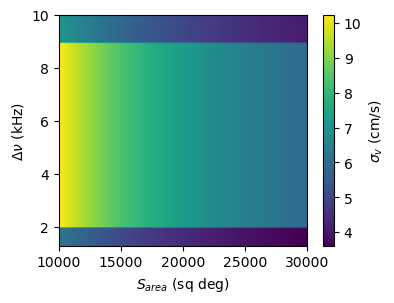

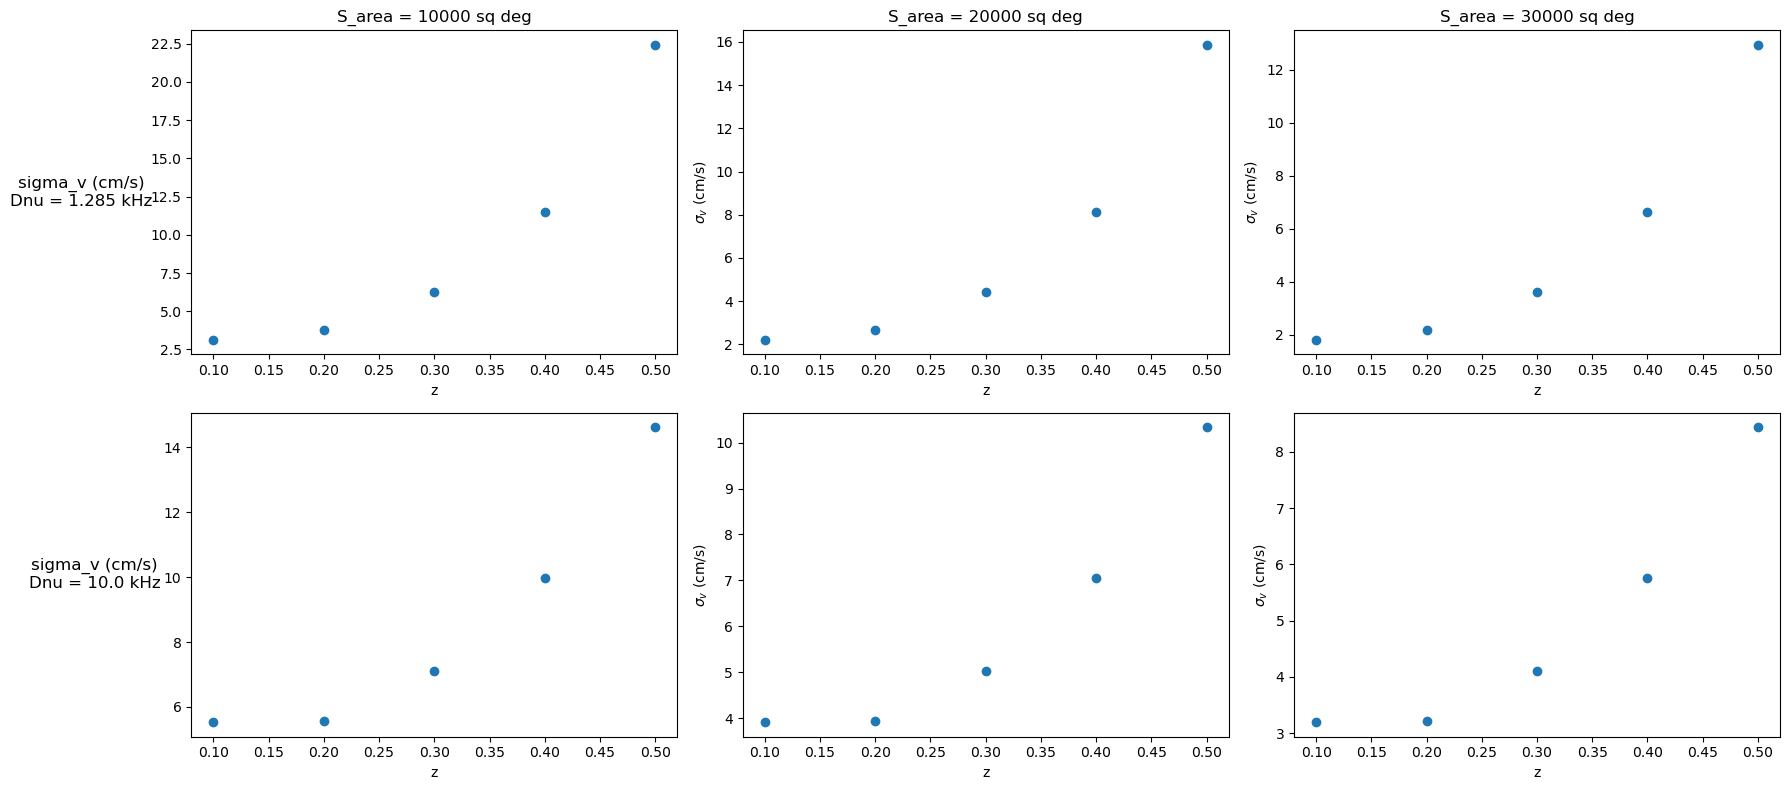

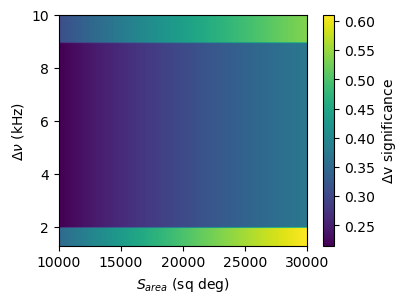

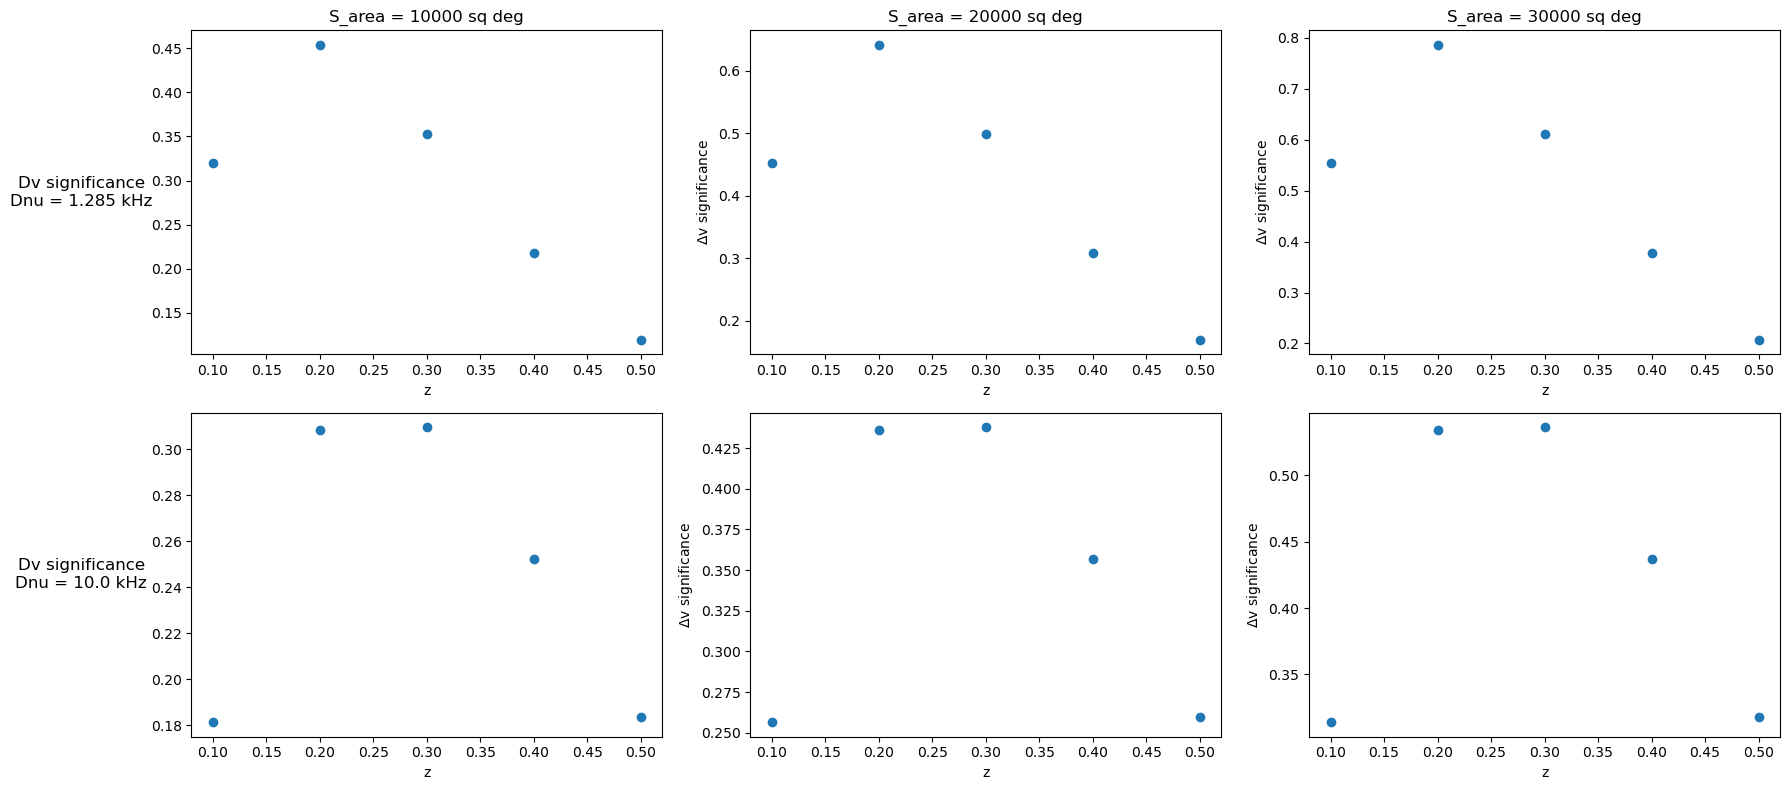

In [17]:
fwhm_def   = 300e5                       # cm/s
z_val      = [0.1, 0.2, 0.3, 0.4, 0.5]   # redshifts
z_eg       = 0.3                         # example redshift
t_obs_def  = 3600*12                     # s
Dnu_val    = [1.285e3, 1e4]              # Hz
S_area_val = [10000, 20000, 30000]       # sq deg
t_exp_def  = 10                          # yr
N_ant_def  = 197                         # integer


#plot_Nz(z_val, Dnu_val, S_area_val, t_obs_def, N_ant_def)

im_sigmav(z_eg, Dnu_val[0], Dnu_val[-1], S_area_val[0], S_area_val[-1], t_obs_def, N_ant_def, fwhm_def, N=100)
plot_sigmav(z_val, Dnu_val, S_area_val, t_obs_def, N_ant_def, fwhm_def)

im_vsignificance(z_eg, Dnu_val[0], Dnu_val[-1], S_area_val[0], S_area_val[-1], t_obs_def, t_exp_def, N_ant_def, fwhm_def, N=100)
plot_vsignificance(z_val, Dnu_val, S_area_val, t_obs_def, t_exp_def, N_ant_def, fwhm_def)

# Final analysis

In [18]:
def analysis_FoM(z, t_obs, t_exp, N_ant, Dnu, S_area, fwhm):
    sigma_v = sigma_v_func(z, t_obs, N_ant, Dnu, S_area, fwhm)
    delta_v = lambda p: delta_v_func(z, p, t_exp)

    F = Fisher_matrix(p_LCDM, delta_v, sigma_v)
    return FoM(F, 1, 2), unc(F) # Figure of Merit between q0 and j0 and uncertainties

def analysis(t_obs, t_exp, N_ant, Dnu, S_area, fwhm): # s, yrs, integer
    z1 = np.array([.3])
    z2 = np.array([.3, .5])
    z3 = np.array([.1, .3, .5])
    
    FoM = np.array([analysis_FoM(z1, t_obs, t_exp, N_ant, Dnu, S_area, fwhm)[0],
                    analysis_FoM(z2, t_obs/2, t_exp, N_ant, Dnu, S_area, fwhm)[0],
                    analysis_FoM(z3, t_obs/3, t_exp, N_ant, Dnu, S_area, fwhm)[0]])
    unc = np.array([analysis_FoM(z1, t_obs, t_exp, N_ant, Dnu, S_area, fwhm)[1],
                    analysis_FoM(z2, t_obs/2, t_exp, N_ant, Dnu, S_area, fwhm)[1],
                    analysis_FoM(z3, t_obs/3, t_exp, N_ant, Dnu, S_area, fwhm)[1]])
    i = np.argmax(FoM)

    if i == 0:
        return f'Array of redshifts: {z1}\nFigure of Merit: {FoM[0]} \nUncertainties of H0, q0, j0: {unc[0]}'
    if i == 1:
        return f'Array of redshifts: {z2}\nFigure of Merit: {FoM[1]} \nUncertainties of H0, q0, j0: {unc[1]}'
    if i == 2:
        return f'Array of redshifts: {z3}\nFigure of Merit: {FoM[2]} \nUncertainties of H0, q0, j0: {unc[2]}'

#print(analysis(t_obs_def, t_exp_def, N_ant_def, Dnu_val[0], S_area_val[0], fwhm_def))